In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import torch

# Preliminaries

from torchtext.data import Field, TabularDataset, BucketIterator, Iterator

# Models

import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification

# Training

import torch.optim as optim

# Evaluation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [2]:
raw_data_path = '~/Downloads/news.csv'
destination_folder = '~/Downloads/transformer_data/'

train_test_ratio = 0.10
train_valid_ratio = 0.80

first_n_words = 200

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [4]:
def trim_string(x):

    x = x.split(maxsplit=first_n_words)
    x = ' '.join(x[:first_n_words])

    return x

In [5]:
# Read raw data
df_raw = pd.read_csv(raw_data_path)

# Prepare columns
df_raw['label'] = (df_raw['label'] == 'FAKE').astype('int')
df_raw['titletext'] = df_raw['title'] + ". " + df_raw['text']
df_raw = df_raw.reindex(columns=['label', 'title', 'text', 'titletext'])

# Drop rows with empty text
df_raw.drop( df_raw[df_raw.text.str.len() < 5].index, inplace=True)

# Trim text and titletext to first_n_words
df_raw['text'] = df_raw['text'].apply(trim_string)
df_raw['titletext'] = df_raw['titletext'].apply(trim_string) 

# Split according to label
df_real = df_raw[df_raw['label'] == 0]
df_fake = df_raw[df_raw['label'] == 1]

# Train-test split
df_real_full_train, df_real_test = train_test_split(df_real, train_size = train_test_ratio, random_state = 1)
df_fake_full_train, df_fake_test = train_test_split(df_fake, train_size = train_test_ratio, random_state = 1)

# Train-valid split
df_real_train, df_real_valid = train_test_split(df_real_full_train, train_size = train_valid_ratio, random_state = 1)
df_fake_train, df_fake_valid = train_test_split(df_fake_full_train, train_size = train_valid_ratio, random_state = 1)

# Concatenate splits of different labels
df_train = pd.concat([df_real_train, df_fake_train], ignore_index=True, sort=False)
df_valid = pd.concat([df_real_valid, df_fake_valid], ignore_index=True, sort=False)
df_test = pd.concat([df_real_test, df_fake_test], ignore_index=True, sort=False)

# Write preprocessed data
df_train.to_csv(destination_folder + '/train.csv', index=False)
df_valid.to_csv(destination_folder + '/valid.csv', index=False)
df_test.to_csv(destination_folder + '/test.csv', index=False)

In [13]:
df_raw.head()

,label,title,text,titletext
0,1,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",You Can Smell Hillary’s Fear. Daniel Greenfiel...
1,1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,Watch The Exact Moment Paul Ryan Committed Pol...
2,0,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,Kerry to go to Paris in gesture of sympathy. U...
3,1,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",Bernie supporters on Twitter erupt in anger ag...
4,0,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,The Battle of New York: Why This Primary Matte...


In [6]:
# Preprocess and prepare

device = "cuda"

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Model parameter
MAX_SEQ_LEN = 128
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)

# Fields

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
fields = [('label', label_field), ('title', text_field), ('text', text_field), ('titletext', text_field)]

# TabularDataset

train, valid, test = TabularDataset.splits(path=destination_folder, train='train.csv', validation='valid.csv',
                                           test='test.csv', format='CSV', fields=fields, skip_header=True)

# Iterators

train_iter = BucketIterator(train, batch_size=16, sort_key=lambda x: len(x.text),
                            device=device, train=True, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=16, sort_key=lambda x: len(x.text),
                            device=device, train=True, sort=True, sort_within_batch=True)
test_iter = Iterator(test, batch_size=16, device=device, train=False, shuffle=False, sort=False)

/home/luke/repos/govhawk_ml/env/lib/python3.8/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/home/luke/repos/govhawk_ml/env/lib/python3.8/site-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/home/luke/repos/govhawk_ml/env/lib/python3.8/site-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please se

In [7]:
test_iter

In [8]:
class BERT(nn.Module):

    def __init__(self):
        super(BERT, self).__init__()

        options_name = "bert-base-uncased"
        self.encoder = BertForSequenceClassification.from_pretrained(options_name)

    def forward(self, text, label):
        loss, text_fea = self.encoder(text, labels=label)[:2]

        return loss, text_fea

In [9]:
# Save and Load Functions

def save_checkpoint(save_path, model, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

def load_checkpoint(load_path, model):
    
    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']


In [10]:
def train(model,
          optimizer,
          criterion = nn.BCELoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 5,
          eval_every = len(train_iter) // 2,
          file_path = destination_folder,
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for (labels, title, text, titletext), _ in train_loader:
            labels = labels.type(torch.LongTensor)           
            labels = labels.to(device)
            titletext = titletext.type(torch.LongTensor)  
            titletext = titletext.to(device)
            output = model(titletext, labels)
            loss, _ = output

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    

                    # validation loop
                    for (labels, title, text, titletext), _ in valid_loader:
                        labels = labels.type(torch.LongTensor)           
                        labels = labels.to(device)
                        titletext = titletext.type(torch.LongTensor)  
                        titletext = titletext.to(device)
                        output = model(titletext, labels)
                        loss, _ = output
                        
                        valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/' + 'model.pt', model, best_valid_loss)
                    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')

model = BERT().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-5)

train(model=model, optimizer=optimizer)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch [1/5], Step [16/160], Train Loss: 0.7362, Valid Loss: 0.6849
Model saved to ==> bert_cl//model.pt
Model saved to ==> bert_cl//metrics.pt
Epoch [1/5], Step [32/160], Train Loss: 0.6897, Valid Loss: 0.6149
Model saved to ==> bert_cl//model.pt
Model saved to ==> bert_cl//metrics.pt
Epoch [2/5], Step [48/160], Train Loss: 0.6617, Valid Loss: 0.5892
Model saved to ==> bert_cl//model.pt
Model saved to ==> bert_cl//metrics.pt
Epoch [2/5], Step [64/160], Train Loss: 0.4872, Valid Loss: 0.4401
Model saved to ==> bert_cl//model.pt
Model saved to ==> bert_cl//metrics.pt
Epoch [3/5], Step [80/160], Train Loss: 0.2801, Valid Loss: 0.2940
Model saved to ==> bert_cl//model.pt
Model saved to ==> bert_cl//metrics.pt
Epoch [3/5], Step [96/160], Train Loss: 0.1662, Valid Loss: 0.2601
Model saved to ==> bert_cl//model.pt
Model saved to ==> bert_cl//metrics.pt
Epoch [4/5], Step [112/160], Train Loss: 0.1314, Valid Loss: 0.3118
Epoch [4/5], Step [128/160], Train Loss: 0.0507, Valid Loss: 0.3411
Epoch 

Model loaded from <== bert_cl//metrics.pt


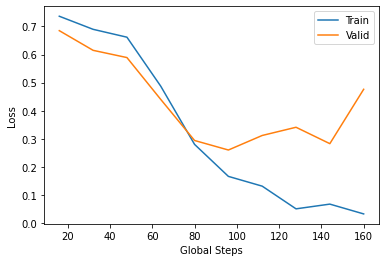

In [11]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Model loaded from <== bert_cl//model.pt
Classification Report:
              precision    recall  f1-score   support

           1     0.9686    0.8423    0.9010      2816
           0     0.8622    0.9730    0.9142      2854

    accuracy                         0.9081      5670
   macro avg     0.9154    0.9077    0.9076      5670
weighted avg     0.9150    0.9081    0.9077      5670



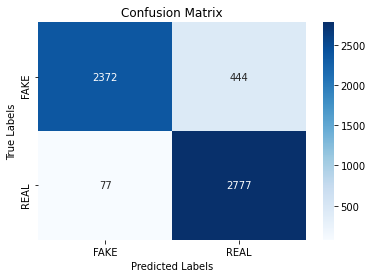

In [12]:

def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (labels, title, text, titletext), _ in test_loader:

                labels = labels.type(torch.LongTensor)           
                labels = labels.to(device)
                titletext = titletext.type(torch.LongTensor)  
                titletext = titletext.to(device)
                output = model(titletext, labels)

                _, output = output
                y_pred.extend(torch.argmax(output, 1).tolist())
                y_true.extend(labels.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
    ax.yaxis.set_ticklabels(['FAKE', 'REAL'])
    
best_model = BERT().to(device)

load_checkpoint(destination_folder + '/model.pt', best_model)

evaluate(best_model, test_iter)